In [ ]:
import time
import pylab
import sqlite3
import seaborn as sns
from datetime import datetime
from matplotlib import pyplot as plt
%matplotlib inline

In [1]:
# Connect to SQLite DB
conn = sqlite3.connect("data/content_digest.db")

# Initialize DB cursor
cur = conn.cursor()

#### Define Functions to Use in Analysis

In [2]:
def query_db(query):
    '''
    Query database and return query as list of lists
    '''
    start = time.time()
    cur.execute(query)
    end = time.time()
    
    print "Query Duration: ",(end-start)/60.0, "Minutes"
    return cur.fetchall()


def plot_clicks_overall(rows, interval):
    '''
    Plot clicks over quarter
    '''
    dates = [datetime.strptime(row[0], "%Y-%m-%d") for row in rows]
    rates = [row[1] for row in rows]
    
    plt.plot(dates, rates)
    plt.xticks(dates[::interval], [x.strftime("%m-%d-%Y") for x in dates[::interval]], rotation=45)
    
    plt.tick_params(axis="x", labelsize=20)
    plt.tick_params(axis="y", labelsize=24)


def plot_clicks_bygroup(rows, interval):
    '''
    Plot clicks of quarter by group
    '''
    for bygroup in list(set(x[1] for x in rows)):
        dates = [datetime.strptime(row[0], "%Y-%m-%d") for row in rows if row[1]==bygroup]
        rates = [row[2] for row in rows if row[1]==bygroup]
        
        plt.plot(dates, rates, label=bygroup)
        plt.xticks(dates[::interval], [x.strftime("%m-%d-%Y") for x in dates[::interval]], rotation=45)

    plt.tick_params(axis="x", labelsize=20)
    plt.tick_params(axis="y", labelsize=24)

#### Look at Overall Click Rate Over 3-Month Period

In [3]:
# Return Total Number of Links Sent to Users
n = query_db("""SELECT COUNT(*) FROM email_content;""")[0][0]
print "Number of Links: ", n

Query Duration:  1.98956033389 Minutes
Number of Links:  10738006


In [4]:
# Return Total Number of Successful Clicks
n = query_db("""SELECT COUNT(*) FROM clicks WHERE status_code=200;""")[0][0]
print "Number of Clicks: ", n

Query Duration:  0.0501307010651 Minutes
Number of Clicks:  1762015


In [5]:
# Return Total Number of UNIQUE Succesful Clicks (e.g. Page Views)
n = query_db("""SELECT COUNT(*) FROM (SELECT DISTINCT user_id, article_id FROM clicks WHERE status_code=200);""")[0][0]
print "Number of Unique Clicks: ", n

Query Duration:  0.370155398051 Minutes
Number of Unique Clicks:  1753249


#### Analyze Click Rate by Time

In [7]:
rows_overall = query_db('''
                        SELECT
                            DATE(email_content.send_time) AS send_date,
                            (100.0*SUM(
                                CASE
                                    WHEN successful_clicks.user_id NOT NULL THEN 1
                                    ELSE 0
                                END) / COUNT(*)
                            ) AS click_rate
                        FROM email_content
                        LEFT JOIN (
                            SELECT DISTINCT
                                user_id,
                                article_id
                            FROM clicks 
                            WHERE status_code=200
                            ) AS successful_clicks
                        ON email_content.user_id = successful_clicks.user_id 
                        AND email_content.article_id = successful_clicks.article_id
                        GROUP BY DATE(email_content.send_time)
                        ORDER BY send_date
                        ;
                        ''')

for row in rows_overall[:5]:
    print row

Query Duration:  4.56651424964 Minutes
(u'2015-01-02', 16.96548097150507)
(u'2015-01-05', 15.973783871846507)
(u'2015-01-06', 16.594085957709378)
(u'2015-01-07', 16.74764780227496)
(u'2015-01-08', 16.72565019047171)


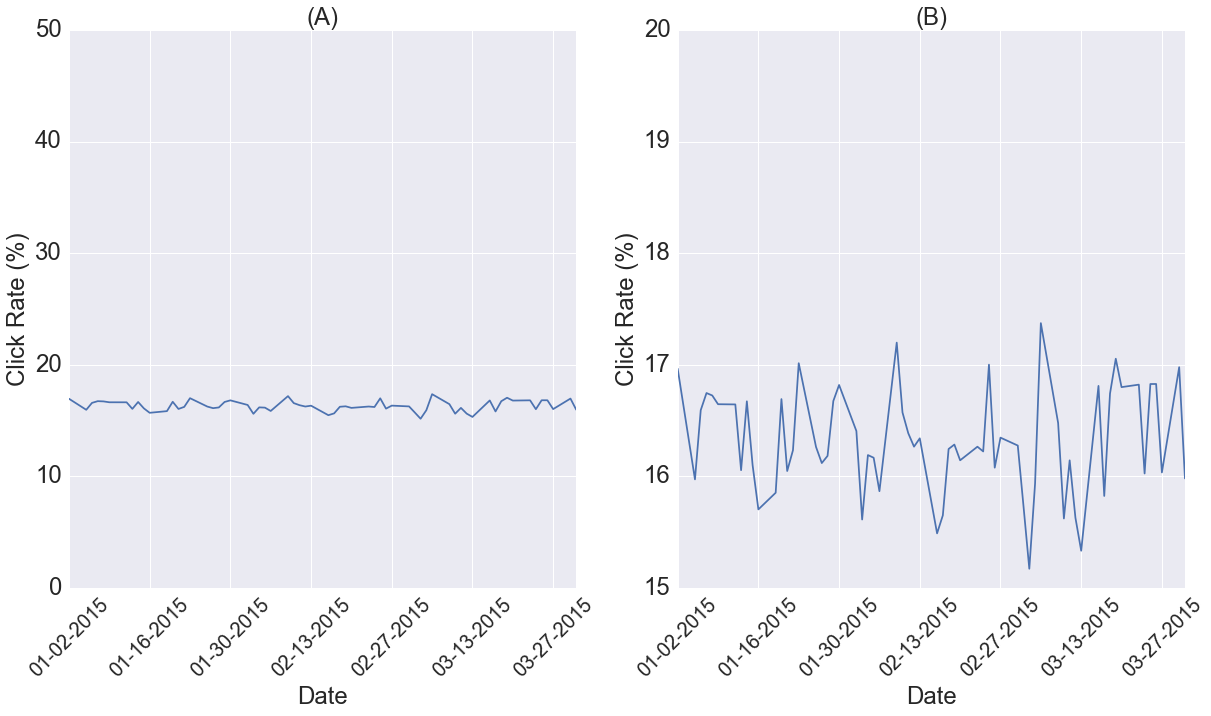

In [11]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plot_clicks_overall(rows_overall, interval=10)
plt.xlabel("Date", fontsize=24)
plt.ylabel("Click Rate (%)", fontsize=24)
plt.title("(A)", fontsize=24)
pylab.ylim([0,50])

plt.subplot(1,2,2)
plot_clicks_overall(rows_overall, interval=10)
plt.xlabel("Date", fontsize=24)
plt.ylabel("Click Rate (%)", fontsize=24)
plt.title("(B)", fontsize=24)
pylab.ylim([15,20])
plt.savefig("graphics/click-rate-overall.png")

#### Analyze Click Rates by Day of Week and Time of Day Sent

In [9]:
rows_by_tod = query_db('''
                        SELECT
                            DATE(email_content.send_time) AS send_date,
                            (CASE
                                WHEN SUBSTR(TIME(email_content.send_time),1,2) IN('08','09','10') THEN '8-11AM'
                                WHEN SUBSTR(TIME(email_content.send_time),1,2) IN('11','12','13') THEN '11AM-2PM'
                                WHEN SUBSTR(TIME(email_content.send_time),1,2) IN('14','15','16','17') THEN '2PM-6PM'
                            END) AS send_time_of_day, 
                            (100.0*SUM(
                                CASE
                                    WHEN successful_clicks.user_id NOT NULL THEN 1
                                    ELSE 0
                                END) / COUNT(*)
                            ) AS click_rate
                        FROM email_content
                        LEFT JOIN (
                            SELECT DISTINCT
                                user_id,
                                article_id
                            FROM clicks 
                            WHERE status_code=200
                            ) AS successful_clicks
                        ON email_content.user_id = successful_clicks.user_id 
                        AND email_content.article_id = successful_clicks.article_id
                        GROUP BY send_date, send_time_of_day
                        ORDER BY send_date, send_time_of_day
                        ;
                        ''')

Query Duration:  7.94128204981 Minutes


In [12]:
rows_by_dow = query_db('''
                        SELECT
                            DATE(email_content.send_time) AS send_date,
                            (CASE 
                                CAST(STRFTIME("%w", email_content.send_time) AS INTEGER)
                                    WHEN 0 THEN "Sunday"
                                    WHEN 1 THEN "Monday"
                                    WHEN 2 THEN "Tuesday"
                                    WHEN 3 THEN "Wednesday"
                                    WHEN 4 THEN "Thursday"
                                    WHEN 5 THEN "Friday"
                                    ELSE "Saturday"
                                END) AS send_day_of_wk,
                            (100.0*SUM(
                                CASE
                                    WHEN successful_clicks.user_id NOT NULL THEN 1
                                    ELSE 0
                                END) / COUNT(*)
                            ) AS click_rate
                        FROM email_content
                        LEFT JOIN (
                            SELECT DISTINCT
                                user_id,
                                article_id
                            FROM clicks 
                            WHERE status_code=200
                            ) AS successful_clicks
                        ON email_content.user_id = successful_clicks.user_id
                        AND email_content.article_id = successful_clicks.article_id
                        GROUP BY send_date, send_day_of_wk
                        ORDER BY send_date, send_day_of_wk
                        ;
                        ''')

Query Duration:  2.66009320021 Minutes


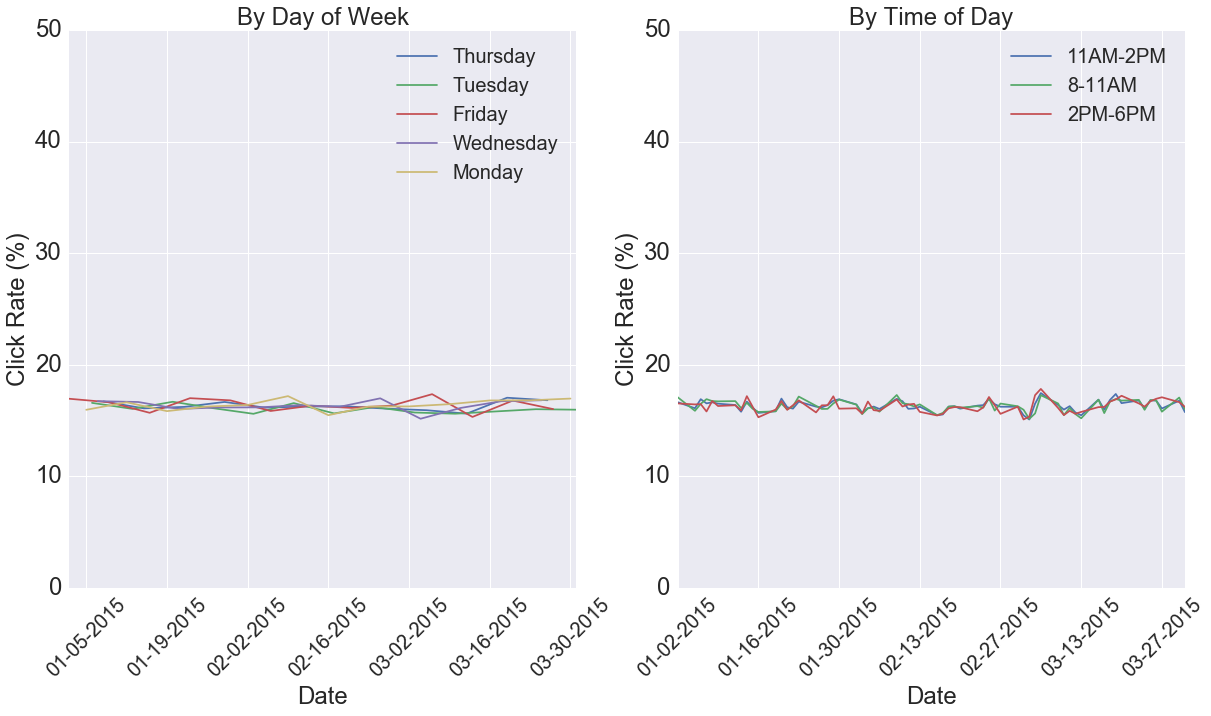

In [13]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plot_clicks_bygroup(rows_by_dow, interval=2)
plt.xlabel("Date", fontsize=24)
plt.ylabel("Click Rate (%)", fontsize=24)
plt.title("By Day of Week", fontsize=24)
plt.legend(loc="best", fontsize=20)
pylab.ylim([0,50])

plt.subplot(1,2,2)
plot_clicks_bygroup(rows_by_tod, interval=10)
plt.xlabel("Date", fontsize=24)
plt.ylabel("Click Rate (%)", fontsize=24)
plt.title("By Time of Day", fontsize=24)
plt.legend(loc="best", fontsize=20)
pylab.ylim([0,50])

plt.savefig("graphics/click-rate-by-time.png")

#### Clicks By Article Type and Topic

##### Create List of Most Common Link Topics & Types

In [14]:
rows = query_db('''
                SELECT
                    topics.name AS topic_name,
                    COUNT(*) AS topic_count
                FROM email_content
                JOIN articles
                    ON email_content.article_id = articles.article_id  
                JOIN topics
                    ON articles.topic_id = topics.topic_id
                GROUP BY topics.name
                ORDER BY topic_name
                ;
                ''')

most_common_topics = []
for each in sorted(rows, key=lambda x: x[1], reverse=True)[:8]:
    most_common_topics.append(each[0].encode("ascii"))

print most_common_topics

Query Duration:  3.05927413305 Minutes
['Entrepreneurship', 'Planning & Forecasting', 'Growth Hacking', 'Web Marketing', 'Personnel Management', 'Business Development', 'Leadership', 'Advertising']


In [15]:
rows = query_db('''
                SELECT
                    types.name AS type_name,
                    COUNT(*) AS type_count
                FROM email_content
                JOIN articles
                    ON email_content.article_id = articles.article_id
                JOIN types 
                    ON articles.type_id = types.type_id
                GROUP BY types.name
                ;
                ''')

most_common_types = []
for each in sorted(rows, key=lambda x: x[1], reverse=True)[:8]:
    most_common_types.append(each[0].encode("ascii"))

print most_common_types

Query Duration:  1.20950598319 Minutes
['News', 'Blog Post', 'Summary', 'Opinion', 'List', 'Webinar', 'Podcast', 'Links']


In [16]:
rows_by_topic = query_db('''
                         SELECT
                            DATE(email_content.send_time) AS send_date,
                            topic.name AS topic_name,
                            (100.0*SUM(
                                CASE
                                    WHEN successful_clicks.user_id NOT NULL THEN 1
                                    ELSE 0
                                END) / COUNT(*)
                            ) AS click_rate
                         FROM email_content
                         
                         JOIN articles
                             ON email_content.article_id = articles.article_id
                             
                         JOIN topics
                             ON articles.topic_id = topics.topic_id
                             
                         LEFT JOIN (
                             SELECT DISTINCT
                                 user_id,
                                 article_id
                             FROM clicks 
                             WHERE status_code=200
                             ) AS successful_clicks
                            ON email_content.user_id = successful_clicks.user_id 
                            AND email_content.article_id = successful_clicks.article_id
                            
                        GROUP BY send_date, topic_name
                        HAVING COUNT(*) > 500
                        ORDER BY send_date, topic_name
                        ;
                        ''')

Query Duration:  2.98655849695 Minutes


In [17]:
rows_by_type = query_db('''
                        SELECT
                            DATE(email_content.send_time) AS send_date,
                            types.name AS type_name,
                            (100.0*SUM(
                                CASE
                                    WHEN successful_clicks.user_id NOT NULL THEN 1
                                    ELSE 0
                                END)/ COUNT(*)
                                ) AS click_rate
                         FROM email_content
                         
                         JOIN articles
                             ON email_content.article_id = articles.article_id
                             
                         JOIN types
                             ON aricles.type_id = types.type_id
                             
                         LEFT JOIN (
                             SELECT DISTINCT
                                 user_id,
                                 article_id
                             FROM clicks 
                             WHERE status_code=200
                             ) AS succesful_clicks
                        ON email_content.user_id = successful_clicks.user_id
                        AND email_content.article_id = succesful_clicks.article_id
                        
                        GROUP BY send_date, type_name
                        HAVING COUNT(*) > 500
                        ORDER BY send_date, type_name
                        ;
                        ''')

Query Duration:  2.46841411591 Minutes


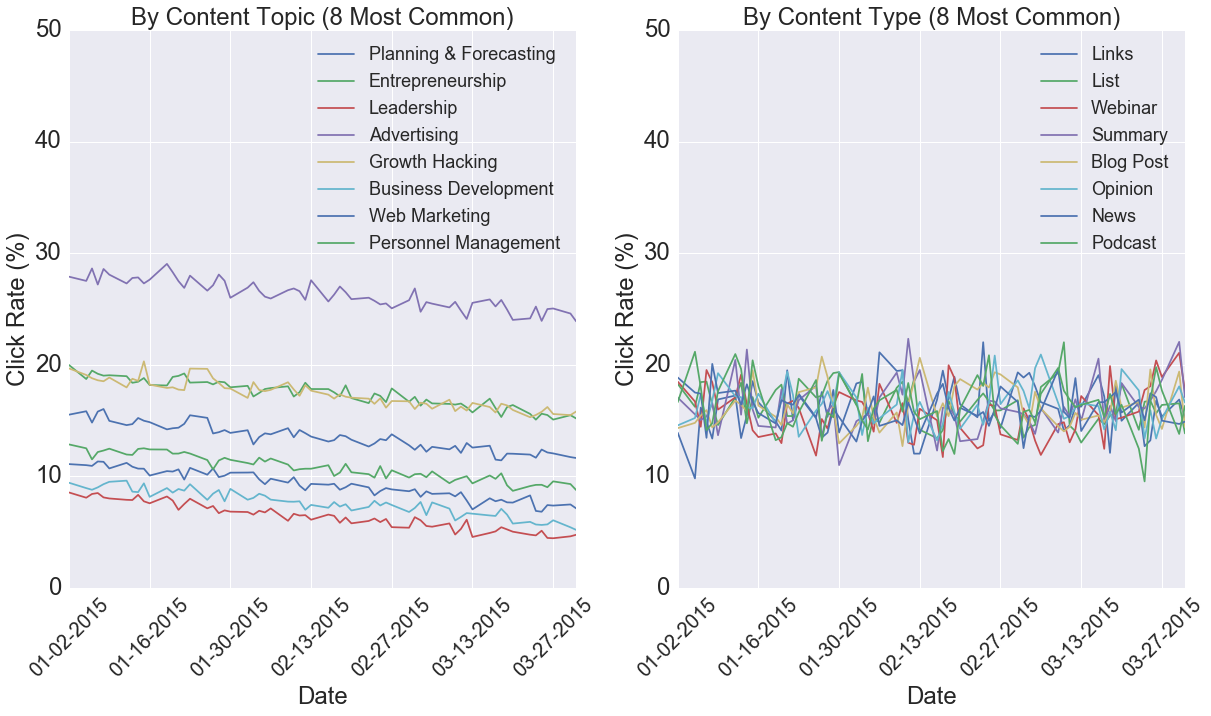

In [18]:
rows_by_common_topic = [x for x in rows_by_topic if x[1] in most_common_topics]
rows_by_common_type =  [x for x in rows_by_type if x[1] in most_common_types ]

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plot_clicks_bygroup(rows_by_common_topic, interval=10)
plt.xlabel("Date", fontsize=24)
plt.ylabel("Click Rate (%)", fontsize=24)
plt.title("By Content Topic (8 Most Common)", fontsize=24)
plt.legend(loc="best", fontsize=18)
pylab.ylim([0,50])

plt.subplot(1,2,2)
plot_clicks_bygroup(rows_by_common_type, interval=10)
plt.xlabel("Date", fontsize=24)
plt.ylabel("Click Rate (%)", fontsize=24)
plt.title("By Content Type (8 Most Common)", fontsize=24)
plt.legend(loc="best", fontsize=18)
pylab.ylim([0,50])

plt.savefig("graphics/clicks-by-content.png")

In [19]:
# Close DB connection
conn.close()